# Notebook 4: Classification

## Introduction

In this notebook we will explore various binary classification algortihms, including Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression, and Naive Bayes. 

We will apply these algorithms to one toy data set, and two real-world datasets: the Pima Indians Diabetes data set; and the Wisconsin Diagnostic Breast Cancer data set. 

We will evaluate performances using three metrics: Classifcation Accuracy, the Receiver Operating Characteristic, and Precision/Recall scores.

## Guidelines

- The structure of the code is given to you and you will need to fill in the parts corresponding to each question. 
- Do not modify/erase other parts of the code if you have not been given specific instructions to do so.
- When you are asked to insert code, do so between the areas which begin:
  
  `##########################################################`
  
  `# TO_DO`
  
  `# [your code here]`
   
   And which end:
   
  `# /TO_DO
   ##########################################################`


- When you are asked to comment on the results you should give clear and comprehensible explanations. Write the comments in a 'Code Cell' with a sign `#` at the beginning of each row, and in the areas which begin:

  `# [INSERT YOUR ANSWER HERE]`

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information about them in their respective documentation. As usual Numpy, Pandas, and Scikit-Learn will be used heavily.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# you may need to import sklearn.lda.LDA and sklearn.qda.QDA instead
# depending on which version you have installed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve

## Toy Data Set

### Generate Toy Data Set:

We being by generating a toy dataset that contains two sets of Gaussian random variables:

In [2]:
np.random.seed(18)

n_sample, n_feature = 200, 2
cov = np.array([[0., -0.2], [0.8, .2]])
X = np.r_[np.dot(np.random.randn(n_sample, n_feature), cov),
          np.dot(np.random.randn(n_sample, n_feature), cov) + np.array([1, 1])]

y = np.hstack((np.zeros(n_sample), np.ones(n_sample)))

### Plot Decision Boundaries:

Next we define a function to plot data points and the decision boundary:

In [3]:
def plot_results(X, y, method, model, idx_plot):
    plt.subplot(1, 3, idx_plot)

    X0, X1 = X[y == 0], X[y == 1]  # data corresponding to classes 0 and 1

    plt.scatter(X0[:, 0], X0[:, 1], color='green')  # class 0
    plt.scatter(X1[:, 0], X1[:, 1], color='blue')  # class 1

    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.contour(xx, yy, Z, [0.5], colors='black')
    
    plt.title(method)

### Make Predictions:
Finally we fit the data using Logistic Regression, LDA, and QDA models, and then visualise the results.

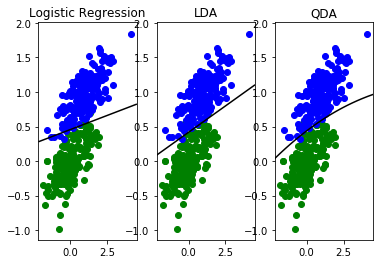

In [4]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X, y)
plot_results(X, y, 'Logistic Regression', lr, 1)

lda = LDA()
lda.fit(X, y)
plot_results(X, y, 'LDA', lda, 2)

qda = QDA()
qda.fit(X, y)
plot_results(X, y, 'QDA', qda, 3)

plt.show()

In [ ]:
lr.

## Pima Indians Diabetes Dataset

The Pima Diabetes Dataset is sampled from Pima people, a group of naive Americans that have developed the highest prevalence of type II diabetes. This is caused by a sudden change of their lifestyle, including diet and physical activities.

The dataset contains data from 768 females with 8 features:

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

The last column indicates if the person is diagnosed with diabetes (value 1) or not (value 0).
<br>
<br>
The original dataset is available at **[UCI Pima Indians Diabetes](http://ftp.ics.uci.edu/pub/machine-learning-databases/pima-indians-diabetes/)**.

### Load Data Set:

The dataset is stored in _pima-indians-diabetes.csv_. Please make sure you have downloaded the file and changed the working directory to where you stored the file. You may want to check `os.chdir` to change directory.

In [5]:
# the following line changes your working directory to 
# your current working directory, you will need to modify the path below
import os
print(os.getcwd())
# read .csv file with pandas.read_csv
data = pd.read_csv('4_pima-indians-diabetes.csv', header=None)

# because the csv file does not contain header information, we manually add
# headers of the dataset
data.columns = ["NumPreg", "PlGlcConc", "BloodP","SkinThick", 
                "SerIns", "BMI","DiPedFunc", "Age", "DiabetesStatus"]

D:\Engineering Files\Engineering year3 Python data science\ucl machine learning minor


In [11]:
data.head()

,NumPreg,PlGlcConc,BloodP,SkinThick,SerIns,BMI,DiPedFunc,Age,DiabetesStatus
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
data.corr()                        #pandas df default function, compute correlation between each column of data

,NumPreg,PlGlcConc,BloodP,SkinThick,SerIns,BMI,DiPedFunc,Age,DiabetesStatus
NumPreg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
PlGlcConc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodP,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThick,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
SerIns,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiPedFunc,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
DiabetesStatus,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


### Visualise Samples:
Use `pandas.DataFrame.head()` to visualise the first several rows of the dataset.

### Plot Correlations:

Use `seaborn.heatmap` to plot pair-wise correlations between features. 

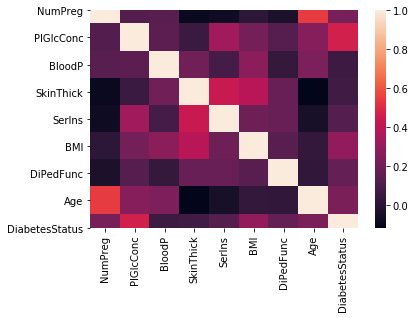

In [7]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### Plot Features - Histogram:

__Task:__  
Generate histograms of the first two features. (You may find `matplotlib.pyplot.histogram` useful). 

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


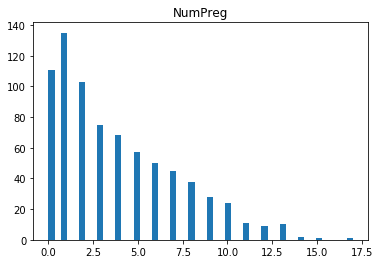

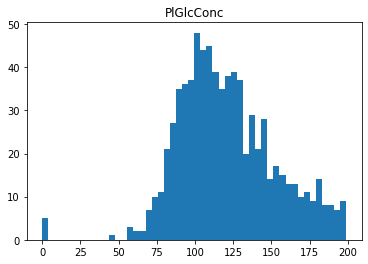

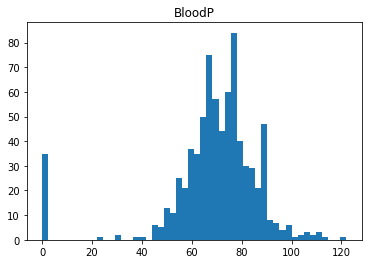

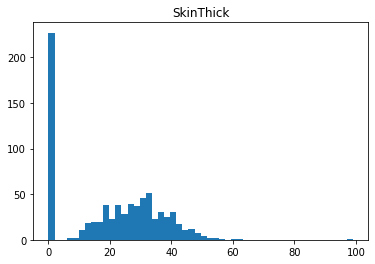

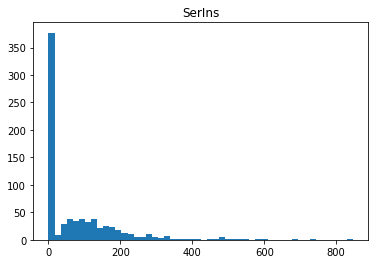

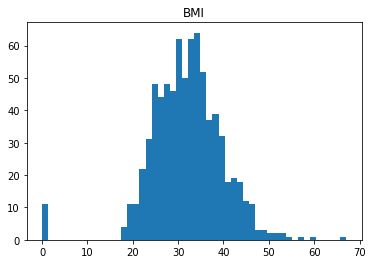

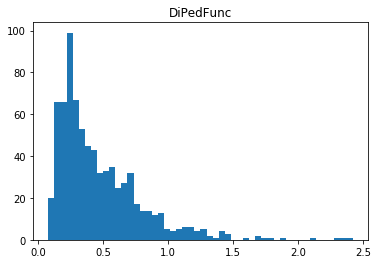

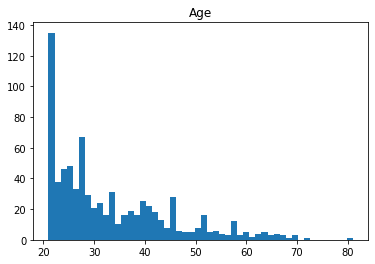

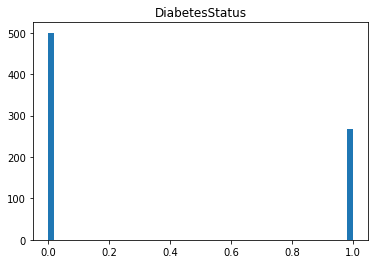

In [18]:
##########################################################
# TO_DO
# data0=[val for idx,val in data.iloc[:,0].iteritems()]
# fig0=plt.figure()
# plt.hist(x=data0,bins=50)
# plt.title(data.columns.values[0])
# fig0.show()

# data1=[val for idx,val in data.iloc[:,1].iteritems()]
# fig1=plt.figure()
# plt.hist(x=data1,bins=50)
# plt.title(data.columns.values[1])
# fig1.show()

# fig2=plt.figure()
# plt.hist(data.iloc[:,2], bins=50)
# plt.title(data.columns.values[2])
# fig2.show()


counter=0
for columns in data.columns.values:                        #use a loop to plot all graphs at once
    fig='fig'+str(counter)
    fig=plt.figure()
    plt.hist(x=data.loc[:,columns],bins=50)
    plt.title(columns)
    counter+=1
    fig.show()

# /TO_DO
##########################################################

Alternatively, we can generate histograms with `pandas.DataFrame.hist`.  

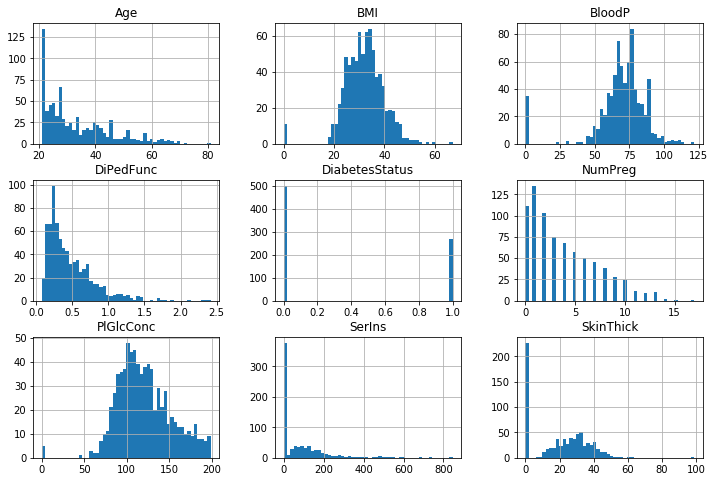

In [11]:
data.hist(bins=50, figsize=(12, 8))
plt.show()

### Plot Features - Box Plot:
Yet another option is `pandas.DataFrame.plot()`. We can also use this to generate Box Plots:

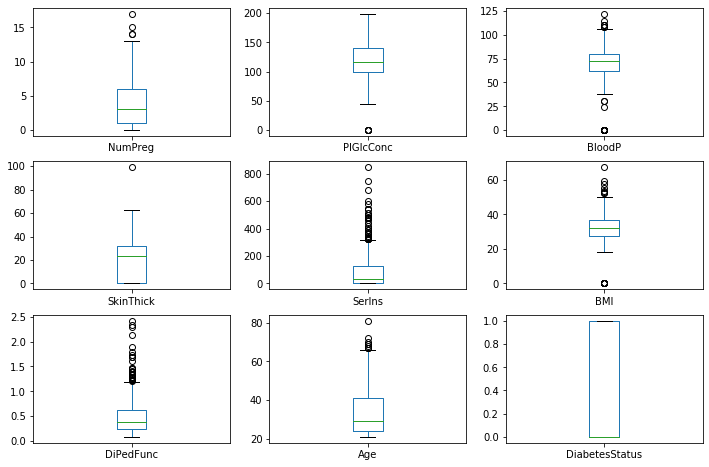

In [17]:
data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12, 8))
plt.show()

### Plot Features - Density Plot:
And Density Plots:

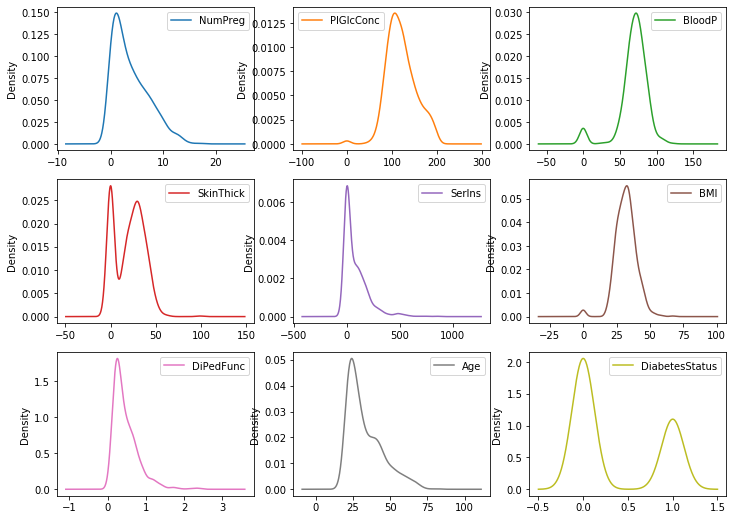

In [19]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12, 9))
plt.show()

### Data Cleansing:

In Week 1, we used `sklearn.preprocessing.Imputer` to clean the data. 

Another option is to use `pandas.DataFrame.replace`, if the type of your dataset is `pandas.DataFrame`.

In this section, missing values of the following features are replaced with the mean value of the corresponding feature column. 

__Task:__  
Clean other features if necessary.

### _Plasma glucose concentration a 2 hours in an oral glucose tolerance test (PlGlcConc)_

In [ ]:
mean_PlGlcConc = data['PlGlcConc'].mean()
data['PlGlcConc'] = data['PlGlcConc'].replace(to_replace=0, value=mean_PlGlcConc)

### _Diastolic blood pressure (BloodP)_

In [20]:
mean_BloodP = data['BloodP'].mean()
data['BloodP'] = data['BloodP'].replace(to_replace=0, value=mean_BloodP)

### _Triceps skin fold thickness (SkinThick)_

In [21]:
mean_SkinThick = data['SkinThick'].mean()
data['SkinThick'] = data['SkinThick'].replace(to_replace=0, value=mean_SkinThick)

### _Other Features_

In [22]:
##########################################################
# TO_DO
for column in data.columns.values:
    data[column]=data[column].replace(to_replace=0,value=data[column].mean())

# /TO_DO
##########################################################

### Split the Data Set:

Before we start, we need to split the data set into a training set and a test set:

In [23]:
# extract labels from the dataset
X, y = data.drop("DiabetesStatus", axis=1), data["DiabetesStatus"].copy()

# split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

### Scale the Data Set:
Next we standardise the data set since the features are reported on different scales. 

Common scaling techniques include normalisation and binarisation. 

`sklearn.preprocessing` provides various feature scaling modules (use `help(preprocessing)` to check the documentation of these modules). 

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression:

In [ ]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
y_lr_prob = lr.predict_proba(X_test)[:, -1]  # probability estimates of the positive class
y_lr_score = lr.decision_function(X_test)  # confidence scores

In [30]:
from sklearn.pipeline import Pipeline
pipe=Pipeline([
              ('scaling',StandardScaler()),
              ('classify',LogisticRegression(solver='lbfgs'))
])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

ValueError: Unknown label type: 'continuous'

### Naive Bayes:

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_test)

### Linear Discriminant Analysis (LDA):

In [ ]:
lda = LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_test)

### Quadratic Discriminant Analysis (QDA):

In [ ]:
qda = QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_test)

### Compare Performances:
Finally we compare the performances with three different metrics: Classification Accuracy, ROC curve, and Precision-Recall score.

### _Classification Accuracy:_
Classification accuracy is perhaps the most popular and (apparently) natural metric for evaluating the performance of a classification algorithm. 

It can be conveniently computed by using `sklearn.metrics.accuracy_score`.

In [ ]:
# create a dictionary variable with keys being algorithms names and values being classification predictions
results = dict(zip(['logistic regression', 'naive bayes', 'LDA', 
               'QDA'],
              [y_lr, y_nb, y_lda, y_qda]))

# create a dictionary variable with keys being algorithm names and values being classification accuracy
accuracy = {}
for algorithm, prediction in results.items():
    accuracy[algorithm] = accuracy_score(y_test, prediction)
    
accuracy = pd.DataFrame(data=accuracy, index=[0])
accuracy

### _ROC Curve:_
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings:

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_lr_prob)  # false positive rates and true positive rates

# plot the ROC curve
fig, axis = plt.subplots()
axis.plot(fpr, tpr)
axis.plot([0, 1], [0, 1], 'k--')
axis.set_xlabel('false positive rate')
axis.set_ylabel('true positive rate')

plt.show()

### _Precision/Recall:_

The Precision/Recall, can be computed as follows:

$$
Precision = \frac{TP}{TP+FP}
$$
$$
Recall = \frac{TP}{TP + FN}
$$

Here *TP* is the number of true positives, *FP* is the number of false positives and *FN* is the number of false negatives. 

The terms 'positive' and 'negative' in the classification context refer to the prediction, and the terms 'true' and 'false' refer to whether the prediction corresponds to the observation.

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_lr_score)  # precision, recall scores

fig, axis = plt.subplots()
axis.plot(thresholds, precision[:-1], label='precision')  # plot precision
axis.plot(thresholds, recall[:-1], label='recall')  # plot recall
axis.set_xlabel('threshold')
plt.legend()

plt.show()

## Wisconsin Diagnostic Breast Cancer Data Set

We have applied several binary classification algorithms to the Pima Indians Diabetes dataset. 

Now we will try a simialr exercise using the Wisconsin Diagnostic Breast Cancer data set (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

The features from the Breast Cancer data set are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  
The data set contains data from 569 females, whose diagosis of breast tissues are either malignant (212 samples) or benign (357 samples).  
The Breast Cancer data set has been pre-processed and cleaned with Scikit-Learn.

### Load Data Set:
The dataset can be loaded with `sklearn.datasets.load_breast_cancer`:

In [ ]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
X = breast_cancer['data']
y = breast_cancer['target']

Descriptions of the columns of the data set can be viewed with the following code:

In [ ]:
print(breast_cancer['DESCR'])

### Split the Data Set:
__Task:__  
Begin by splitting the data set into train and test parts:

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################

### Logistic regression:
__Task:__  
Next apply the Logistic Regression algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_lr`: 

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################

### Naive Bayes:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_nb`: 

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################

### LDA:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_lda`: 

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################

### QDA:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_qda`: 

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################

### Compare Performances:

__Task:__  
Finally, compare performances of your classification algorithms and visualise your results:

In [ ]:
##########################################################
# TO_DO


# /TO_DO
##########################################################